<a href="https://colab.research.google.com/github/HasanNayon/Anomaly-detection/blob/main/ad.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tarfile
tar_file = '/content/drive/MyDrive/new/mvtec_anomaly_detection.tar.xz'
destination = '/content/mvtec_anomaly_detection'

with tarfile.open(tar_file, 'r:*') as tar:
    tar.extractall(path=destination)


In [17]:
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.metrics import roc_auc_score
from skimage import morphology
from sklearn.model_selection import train_test_split

In [18]:
# MVTec Data Loader
def load_mvtec_dataset(dataset_path, category='bottle', mode='train', target_size=(256, 256)):

    normal_path = os.path.join(dataset_path, category, mode, 'good')
    normal_images = []

    # Load normal images
    for img_name in sorted(os.listdir(normal_path)):
        img_path = os.path.join(normal_path, img_name)
        img = tf.io.read_file(img_path)
        img = tf.image.decode_png(img, channels=3)
        img = tf.image.resize(img, target_size)
        normal_images.append(img)

    if mode == 'train':
        return tf.stack(normal_images) / 255.0

    # For test mode, load all defect types
    defect_types = [d for d in os.listdir(os.path.join(dataset_path, category, 'test'))
                  if d != 'good']

    test_images = []
    test_masks = []

    for defect in defect_types:
        defect_path = os.path.join(dataset_path, category, 'test', defect)
        mask_path = os.path.join(dataset_path, category, 'ground_truth', defect)

        for img_name in sorted(os.listdir(defect_path)):
            # Load image
            img = tf.io.read_file(os.path.join(defect_path, img_name))
            img = tf.image.decode_png(img, channels=3)
            img = tf.image.resize(img, target_size)

            # Load mask (if exists)
            mask_name = img_name.replace('.png', '_mask.png')
            if os.path.exists(os.path.join(mask_path, mask_name)):
                mask = tf.io.read_file(os.path.join(mask_path, mask_name))
                mask = tf.image.decode_png(mask, channels=1)
                mask = tf.image.resize(mask, target_size)
                mask = tf.cast(mask > 0, tf.float32)
            else:
                mask = tf.zeros(target_size + (1,), dtype=tf.float32)

            test_images.append(img)
            test_masks.append(mask)

    return (tf.stack(normal_images)/255.0,
            tf.stack(test_images)/255.0,
            tf.stack(test_masks))

In [19]:
# Model Architecture
def build_mvtec_autoencoder(input_shape=(256, 256, 3)):
    """Autoencoder optimized for MVTec dataset"""
    inputs = layers.Input(shape=input_shape)

    # Encoder
    x = layers.Conv2D(32, (4, 4), activation='relu', padding='same', strides=2)(inputs)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)

    x = layers.Conv2D(64, (4, 4), activation='relu', padding='same', strides=2)(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)

    x = layers.Conv2D(128, (4, 4), activation='relu', padding='same', strides=2)(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)

    # Decoder
    x = layers.Conv2DTranspose(128, (4, 4), activation='relu', padding='same', strides=2)(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)

    x = layers.Conv2DTranspose(64, (4, 4), activation='relu', padding='same', strides=2)(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)

    x = layers.Conv2DTranspose(32, (4, 4), activation='relu', padding='same', strides=2)(x)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)

    outputs = layers.Conv2D(3, (1, 1), activation='sigmoid')(x)

    return models.Model(inputs, outputs)


In [21]:
#Training with MVTec-specific Setup

# Load data
dataset_path = '/content/mvtec_anomaly_detection'
category = 'bottle'

# Load training images and convert to NumPy array
train_images_tf = load_mvtec_dataset(dataset_path, category, 'train')
train_images_np = train_images_tf.numpy() # Convert TensorFlow tensor to NumPy array

# Load test data
_, test_images, test_masks = load_mvtec_dataset(dataset_path, category, 'test')


# Split train into train/val using the NumPy array
train_images, val_images = train_test_split(train_images_np, test_size=0.1, random_state=42)

# Convert the split NumPy arrays back to TensorFlow tensors for training
train_images = tf.convert_to_tensor(train_images)
val_images = tf.convert_to_tensor(val_images)

In [22]:
# Build and compile model
autoencoder = build_mvtec_autoencoder()
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss='mse')

In [26]:
autoencoder.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_30 (Conv2D)              │ (None, 128, 128, 32)   │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (None, 128, 128, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_32 (Conv2D)              │ (None, 64, 64, 64)     │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_33 (Conv2D)              │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_34 (Conv2D)              │ (None, 32, 32, 128)    │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_35 (Conv2D)              │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_9              │ (None, 64, 64, 128)    │       262,272 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_36 (Conv2D)              │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_10             │ (None, 128, 128, 64)   │       131,136 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_37 (Conv2D)              │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_11             │ (None, 256, 256, 32)   │        32,800 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_38 (Conv2D)              │ (None, 256, 256, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_39 (Conv2D)              │ (None, 256, 256, 3)    │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 979,427 (3.74 MB)

 Trainable params: 979,427 (3.74 MB)

 Non-trainable params: 0 (0.00 B)

In [27]:
# Callbacks
checkpoint = callbacks.ModelCheckpoint(
    f'mvtec_{category}_best.h5',
    save_best_only=True,
    monitor='val_loss',
    mode='min'
)


In [28]:
early_stop = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True
)

In [29]:
# Train
history = autoencoder.fit(
    train_images, train_images,
    validation_data=(val_images, val_images),
    epochs=20,
    batch_size=32,
    callbacks=[checkpoint, early_stop]
)

Epoch 1/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 560ms/step - loss: 0.1316

6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 763ms/step - loss: 0.1317 - val_loss: 0.1172
Epoch 2/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 268ms/step - loss: 0.1225 - val_loss: 0.1185
Epoch 3/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - loss: 0.1097

6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 267ms/step - loss: 0.1089 - val_loss: 0.0913
Epoch 4/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - loss: 0.0825

6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 267ms/step - loss: 0.0816 - val_loss: 0.0681
Epoch 5/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - loss: 0.0610

6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 266ms/step - loss: 0.0604 - val_loss: 0.0473
Epoch 6/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 243ms/step - loss: 0.0485 - val_loss: 0.0495
Epoch 7/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step - loss: 0.0459

6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 261ms/step - loss: 0.0458 - val_loss: 0.0439
Epoch 8/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - loss: 0.0423

6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 285ms/step - loss: 0.0423 - val_loss: 0.0399
Epoch 9/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - loss: 0.0398

6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 292ms/step - loss: 0.0398 - val_loss: 0.0391
Epoch 10/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - loss: 0.0385

6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 266ms/step - loss: 0.0384 - val_loss: 0.0374
Epoch 11/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - loss: 0.0371

6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 265ms/step - loss: 0.0370 - val_loss: 0.0361
Epoch 12/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step - loss: 0.0357

6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 274ms/step - loss: 0.0357 - val_loss: 0.0344
Epoch 13/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - loss: 0.0335

6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 269ms/step - loss: 0.0333 - val_loss: 0.0234
Epoch 14/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - loss: 0.0168

6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 284ms/step - loss: 0.0163 - val_loss: 0.0060
Epoch 15/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - loss: 0.0063

6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 295ms/step - loss: 0.0063 - val_loss: 0.0048
Epoch 16/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - loss: 0.0049

6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 286ms/step - loss: 0.0048 - val_loss: 0.0042
Epoch 17/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - loss: 0.0042

6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 285ms/step - loss: 0.0041 - val_loss: 0.0036
Epoch 18/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - loss: 0.0036

6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 271ms/step - loss: 0.0036 - val_loss: 0.0033
Epoch 19/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step - loss: 0.0033

6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 272ms/step - loss: 0.0033 - val_loss: 0.0031
Epoch 20/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step - loss: 0.0031

6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 297ms/step - loss: 0.0031 - val_loss: 0.0030


In [30]:
# MVTec-specific Evaluation Metrics

def evaluate_mvtec(model, test_images, test_masks):
    # Get reconstructions and error maps
    reconstructions = model.predict(test_images)
    error_maps = np.mean(np.abs(test_images - reconstructions), axis=-1)

    # Need to convert test_masks to numpy to flatten
    flat_masks = test_masks.numpy().reshape(-1)
    flat_errors = error_maps.reshape(-1)

    # Compute image-level AUROC
    img_level_scores = np.max(error_maps, axis=(1, 2))
    # Need to convert test_masks to numpy for numpy max
    img_level_labels = np.max(test_masks.numpy(), axis=(1, 2, 3))
    img_auroc = roc_auc_score(img_level_labels, img_level_scores)

    # Compute pixel-level AUROC
    pixel_auroc = roc_auc_score(flat_masks, flat_errors)

    # Compute PRO (Per-Region Overlap)
    pro_scores = []
    max_error = np.max(error_maps)
    if max_error > 0:
        thresholds = np.linspace(0, max_error, 100)
    else:
        thresholds = [0]
    # Store overlaps for each threshold to calculate the PRO AUC at the end
    overlaps_at_thresholds = []

    for thresh in thresholds:
        binary_maps = (error_maps > thresh).astype(bool)
        current_threshold_overlaps = []

        for i in range(len(test_masks)):
            # Need to convert test_masks[i] to numpy for sum
            if np.sum(test_masks[i].numpy()) > 0:
                cleaned = morphology.remove_small_objects(
                    morphology.remove_small_holes(
                        binary_maps[i],
                    area_threshold=32),
                min_size=32)
                mask_np_bool = tf.squeeze(test_masks[i]).numpy().astype(bool)

                # Perform bitwise AND between the boolean arrays
                intersection = np.sum(cleaned & mask_np_bool)
                # Convert test_masks[i] to numpy for sum
                union = np.sum(test_masks[i].numpy())
                current_threshold_overlaps.append(intersection / union if union > 0 else 0)

        # Store the mean overlap for this threshold
        if current_threshold_overlaps:
             overlaps_at_thresholds.append(np.mean(current_threshold_overlaps))
        else:
             overlaps_at_thresholds.append(0)

    # Use np.trapz for integration.
    if len(thresholds) > 1:
        pro_score = np.trapz(overlaps_at_thresholds, thresholds) / (thresholds[-1] - thresholds[0])
    elif thresholds[0] == 0 and overlaps_at_thresholds:
        pro_score = overlaps_at_thresholds[0]
    else:
        pro_score = 0

    return {
        'image_auroc': img_auroc,
        'pixel_auroc': pixel_auroc,
        'pro_score': pro_score
    }

In [31]:
# Evaluate
metrics = evaluate_mvtec(autoencoder, test_images, test_masks)
print(f"Image-Level AUROC: {metrics['image_auroc']:.4f}")
print(f"Pixel-Level AUROC: {metrics['pixel_auroc']:.4f}")
print(f"PRO Score: {metrics['pro_score']:.4f}")


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 506ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Image-Level AUROC: nan
Pixel-Level AUROC: 0.6978
PRO Score: 0.0838


<ipython-input-30-371b9bcfc66d>:59: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  pro_score = np.trapz(overlaps_at_thresholds, thresholds) / (thresholds[-1] - thresholds[0])


In [32]:
# Visualization for MVTec Defects

def visualize_mvtec_results(images, masks, reconstructions, num_samples=5):
    """Visualize MVTec test cases with ground truth masks"""
    indices = np.random.choice(len(images), num_samples)

    plt.figure(figsize=(15, 4*num_samples))
    for i, idx in enumerate(indices):
        image_np = images[idx].numpy() if isinstance(images[idx], tf.Tensor) else images[idx]
        error_map = np.mean(np.abs(image_np - reconstructions[idx]), axis=-1)

        plt.subplot(num_samples, 4, i*4 + 1)
        # images[idx] might be a TensorFlow Tensor, convert to numpy for plotting
        plt.imshow(image_np)
        plt.title("Original Image")
        plt.axis('off')

        plt.subplot(num_samples, 4, i*4 + 2)
        plt.imshow(reconstructions[idx])
        plt.title("Reconstruction")
        plt.axis('off')

        plt.subplot(num_samples, 4, i*4 + 3)
        plt.imshow(error_map, cmap='jet')
        plt.title("Error Map")
        plt.axis('off')

        plt.subplot(num_samples, 4, i*4 + 4)
        # test_masks is a TensorFlow Tensor, so .numpy() is needed here
        plt.imshow(tf.squeeze(masks[idx]).numpy(), cmap='gray')
        plt.title("Ground Truth")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 579ms/step


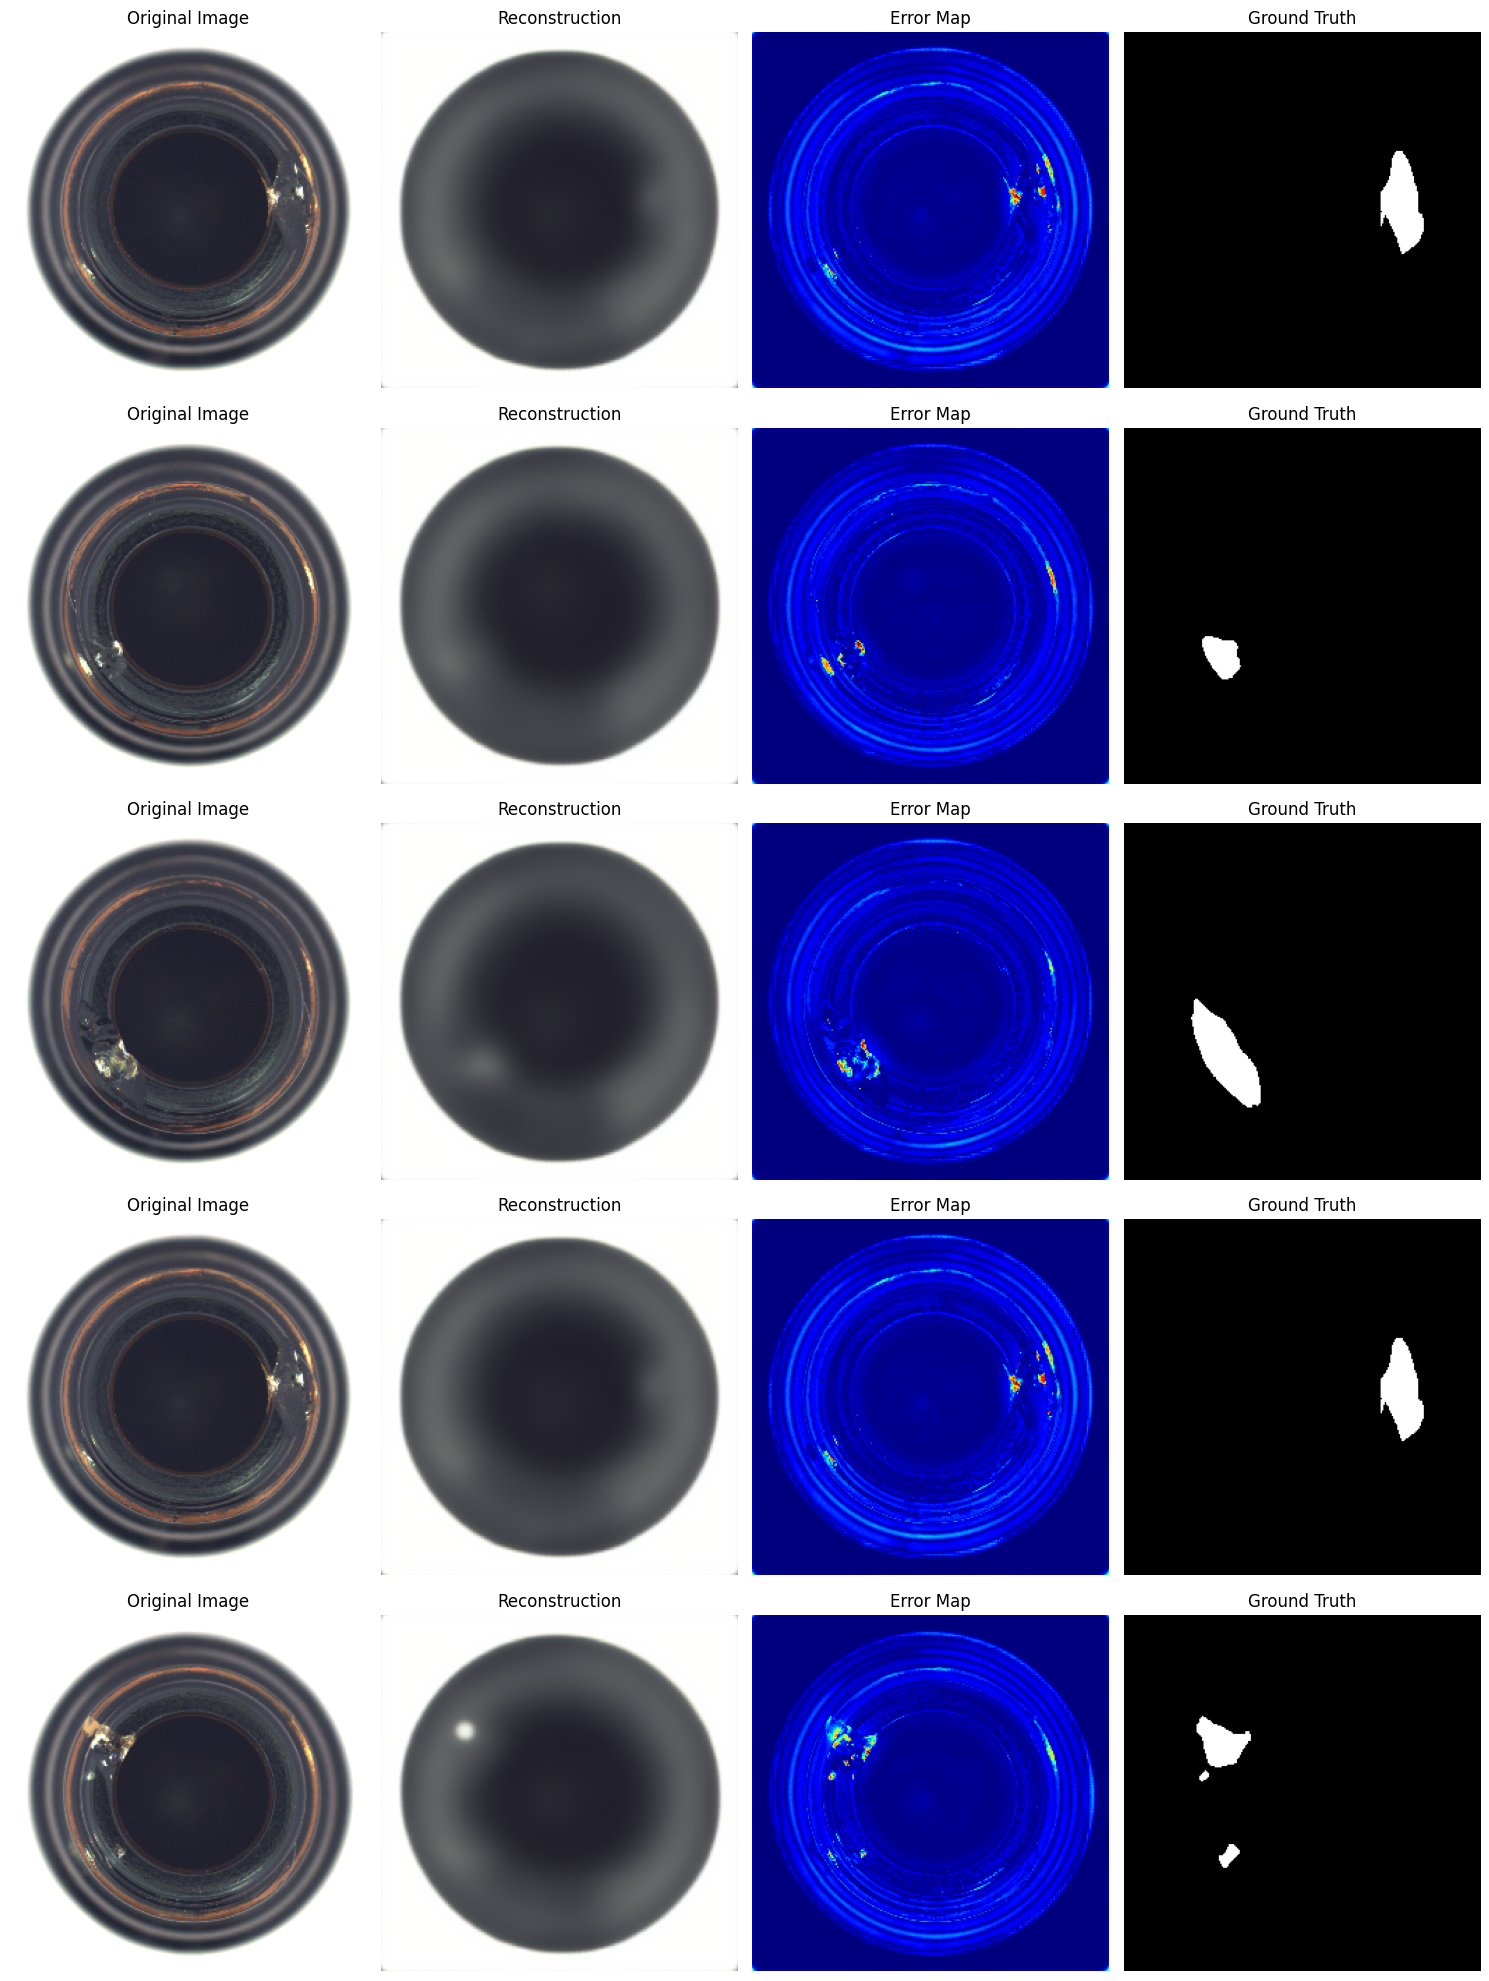

In [33]:
# Visualize some test cases
test_reconstructions = autoencoder.predict(test_images[:20])
visualize_mvtec_results(test_images[:20], test_masks[:20], test_reconstructions)